### Implementation of your own block matching algorithm for stereo depth reconstruction. 


You are not allowed to use cv2.matchTemplate, cv2.stereoBM or similar functions from opencv or other pre-existing libraries

1. Implement a function that takes two equal size images and calculates the sum of absolute differences. The two equal-sized images are nose_left.png (used as the template) and nose_right.png.

2. Using the function you just created, find which of the three images nose1.png, nose2.png, nose3.png gives the best match to nose_left.png?

3. Since these images are rectified, we can approximately assume that a pixel found in row x in the left image also lives in row x in the right image. nose_span.png contains the entire row containing the nose of the sculpture. The height of the span is 7 - the same height as your template. Write a function that loops through the image from left to right and computes the correlation using your function from step 1 to find where in the span the nose is located.


In [26]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
plt.gray()

<Figure size 432x288 with 0 Axes>

## Initial images

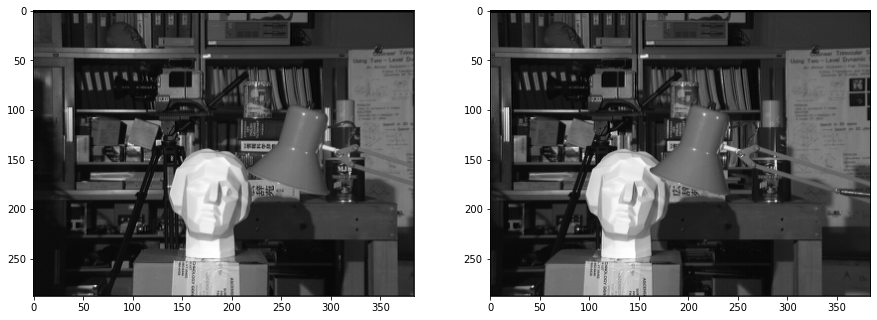

In [21]:
img_left = cv2.imread("tsukuba_left.png")
img_right = cv2.imread("tsukuba_right.png")

img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
gray_left = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)

img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
gray_right= cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

f, axarr = plt.subplots(1,2, figsize = (15,15))
axarr[0].imshow(gray_left)
axarr[1].imshow(gray_right)

## Noses

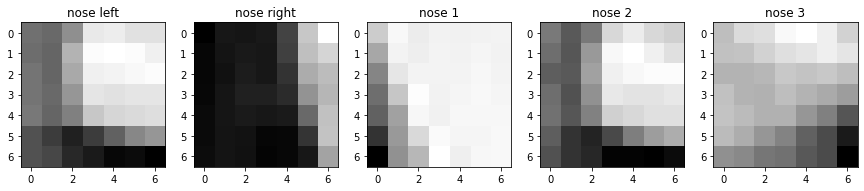

In [25]:
nose_left = cv2.imread("nose_left.png")
nose_right = cv2.imread("nose_right.png")
noses = [cv2.imread("nose1.png"), cv2.imread("nose2.png"), cv2.imread("nose3.png")]

nose_left = cv2.cvtColor(nose_left, cv2.COLOR_BGR2RGB)
nose_gray_left = cv2.cvtColor(nose_left, cv2.COLOR_RGB2GRAY)

nose_right = cv2.cvtColor(nose_right, cv2.COLOR_BGR2RGB)
nose_gray_right= cv2.cvtColor(nose_right, cv2.COLOR_RGB2GRAY)

noses_gray = []
for i, nose in enumerate(noses):
    nose = cv2.cvtColor(nose, cv2.COLOR_BGR2RGB)
    noses_gray.append(cv2.cvtColor(nose, cv2.COLOR_RGB2GRAY))
    
f, axarr = plt.subplots(1,5, figsize = (15,15))
axarr[0].imshow(nose_gray_left)
axarr[0].set_title("nose left")
axarr[1].imshow(nose_gray_right)
axarr[1].set_title("nose right")
for i, nose in enumerate(noses_gray):
    axarr[2+i].imshow(nose)
    axarr[2+i].set_title(f"nose {i+1}")
    

## Absolute differences

In [ ]:
def absoluteDifference(img1, img2):
    return None

print(absoluteDifference(nose_left, nose_right))

## Best match for nose left

In [ ]:
diff = [absoluteDifference(nose_gray_left, nose) for nose in noses]
print(f"Best matching image: nose {np.argmin(diff)+1}")

## Span best correlation

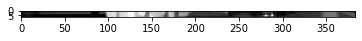

In [36]:
nose_span = cv2.imread("nose_span.png")

nose_span = cv2.cvtColor(nose_span, cv2.COLOR_BGR2RGB)
nose_span_grey = cv2.cvtColor(nose_span, cv2.COLOR_RGB2GRAY)

plt.imshow(nose_span_grey)
plt.figsize = (15,15)

In [41]:
kernel_size =  len(nose_gray_left[0]), len(nose_gray_left)
span_size = len(nose_span_grey[0]), len(nose_span_grey),
print(f"kernel size is {kernel_size}")
print(f"span size is {span_size}")



kernel size is (7, 7)
span size is (384, 7)
